# Explore Cell Cutoffs

We are unsatisfied with out current cutoffs for calling a cell vs background. We think cell ranger's cutoff is too arbitrary, so I need to import the unfiltered data and figure out our own filtering criteria.

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tables

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.cell_selection import cellranger_counts, store_umi, cellranger_umi, decompress_seq, _build_decode

# Setup notebook
nbconfig = Nb.setup_notebook()

# Get datastore
store = pd.HDFStore('../output/store.h5')

last updated: 2018-03-21 
Git hash: f3feea25f97cc8dd6fe210210fde2c42d1695536


In [ ]:
store_umi('../output/testis1/outs/molecule_info.h5', store, 'testis1/umi')

cell_id
umi
write


In [24]:
%%time
store['testis1/umi'].groupby('umi').size()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


KeyboardInterrupt: 

In [ ]:
store['testis1/umi'].shape

In [2]:
def get_umi(name):
    umi = cellranger_umi(f'../output/{name}/outs/molecule_info.h5').groupby("cell_id").umi.size().sort_values(ascending=False).to_frame()
    umi['X'] = range(1, len(umi) + 1)
    return umi


def get_genes(filtered, name, cutoff):
    cell_ids = filtered.index.unique().tolist()
    fname = f'../output/{name}/outs/raw_gene_bc_matrices_h5.h5'
    raw = cellranger_counts(fname, barcodes=cell_ids)
    raw.to_csv(f'../output/{name}/umi_filtered_{cutoff}_gene_counts.tsv', sep='\t')

    
def gene_count(name, cutoff):
    raw = pd.read_csv(f'../output/{name}/umi_filtered_{cutoff}_gene_counts.tsv', sep='\t')
    return (raw.sum(axis=1) > 0).sum()


def _plot_cutoff(ax, cutoff):
    ax.axhline(cutoff, color=nbconfig.color_c1, ls='--', label=f'Cutoff: {cutoff:,}')
    ax.legend()
    
    
def _plot_all(umi, name, ax):
    rep = int(name[-1:])
    ax.plot(umi['X'], umi['umi'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cell Count (log10)')
    ax.set_ylabel('UMI Count (log10)')
    ax.set_title(f'Barcode Rank Plot (Rep {rep})')

    
def _plot_filtered(filtered, name, ax, cutoff):
    size = len(filtered)
    num_genes = gene_count(name, cutoff)
    rep = int(name[-1:])
    
    ax.plot(filtered['X'], filtered['umi'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Cell Count (log10)')
    ax.set_ylabel('UMI Count (log10)')
    ax.text(
        1, 
        10, 
        f"""\
        Number Cells:     {size:,}
        Number Genes ≥ 0: {num_genes:,}
        """
   )
    ax.set_title(f'Filtered Barcode UMI Plot (Rep {rep}: {size:,} Cells)')

In [3]:
def check_cutoff(umi_cutoff):
    for rep in [1, 2, 3]:
        print(f'Parsing Rep {rep}')
        name = f'testis{rep}'
        umi = get_umi(name)
        filtered = umi.query(f'umi > {umi_cutoff}')
        raw = get_genes(filtered, name, umi_cutoff)

def plot_cutoff(umi_cutoff):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 10))
    
    for rep in [1, 2, 3]:
        ax1 = axes[0, rep - 1]
        ax2 = axes[1, rep - 1]
        name = f'testis{rep}'
        umi = get_umi(name)
        filtered = umi.query(f'umi > {umi_cutoff}')
        
        _plot_all(umi, name, ax1)
        _plot_filtered(filtered, name, ax2, umi_cutoff)

    for ax in axes.flatten():
        _plot_cutoff(ax, umi_cutoff)
        
    plt.suptitle(f'UMI Cutoff: {umi_cutoff:,}')
    plt.tight_layout(rect=[0, 0, 1, .95])

In [122]:
check_cutoff(1000)

Parsing Rep 1
Parsing Rep 2
Parsing Rep 3


In [123]:
check_cutoff(5000)

Parsing Rep 1
Parsing Rep 2
Parsing Rep 3


In [ ]:
check_cutoff(10000)

Parsing Rep 1
Parsing Rep 2
Parsing Rep 3


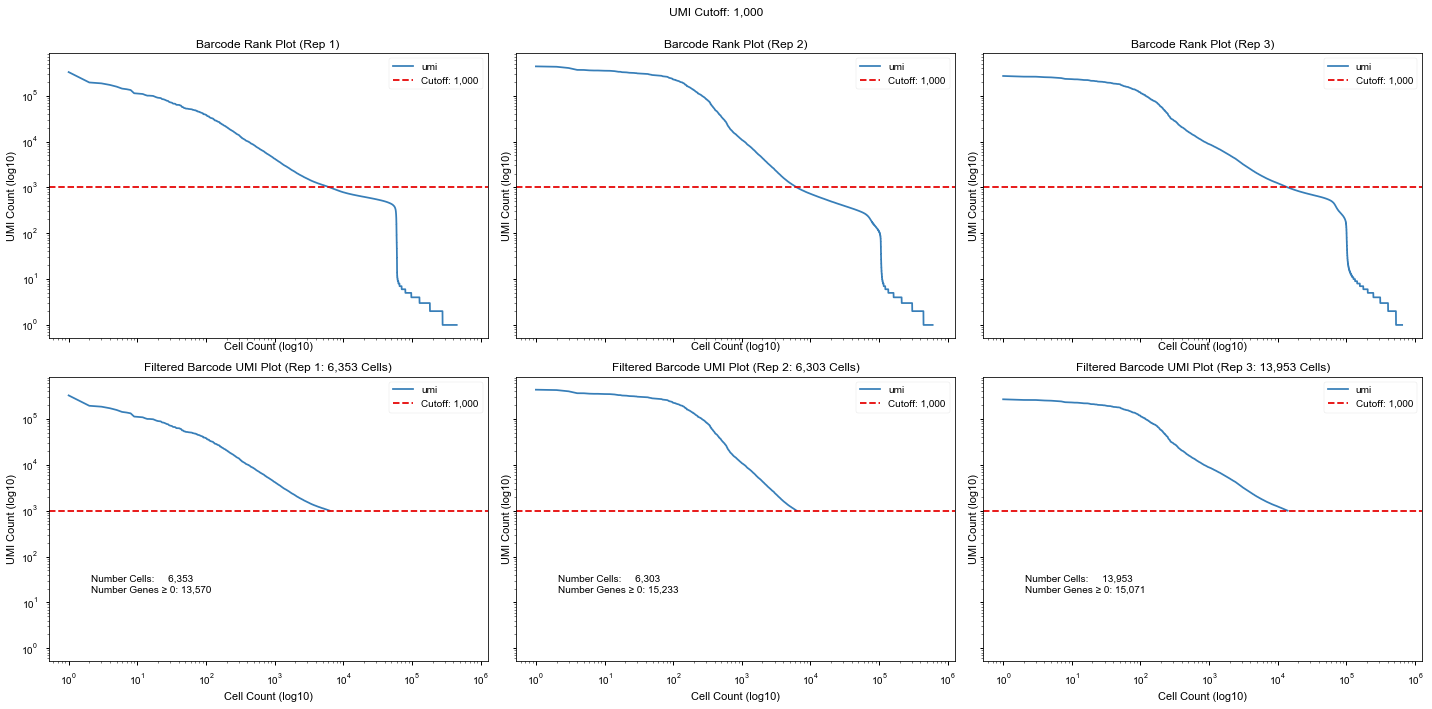

In [4]:
plot_cutoff(1000)

CPU times: user 56.9 s, sys: 10.5 s, total: 1min 7s
Wall time: 3min 14s


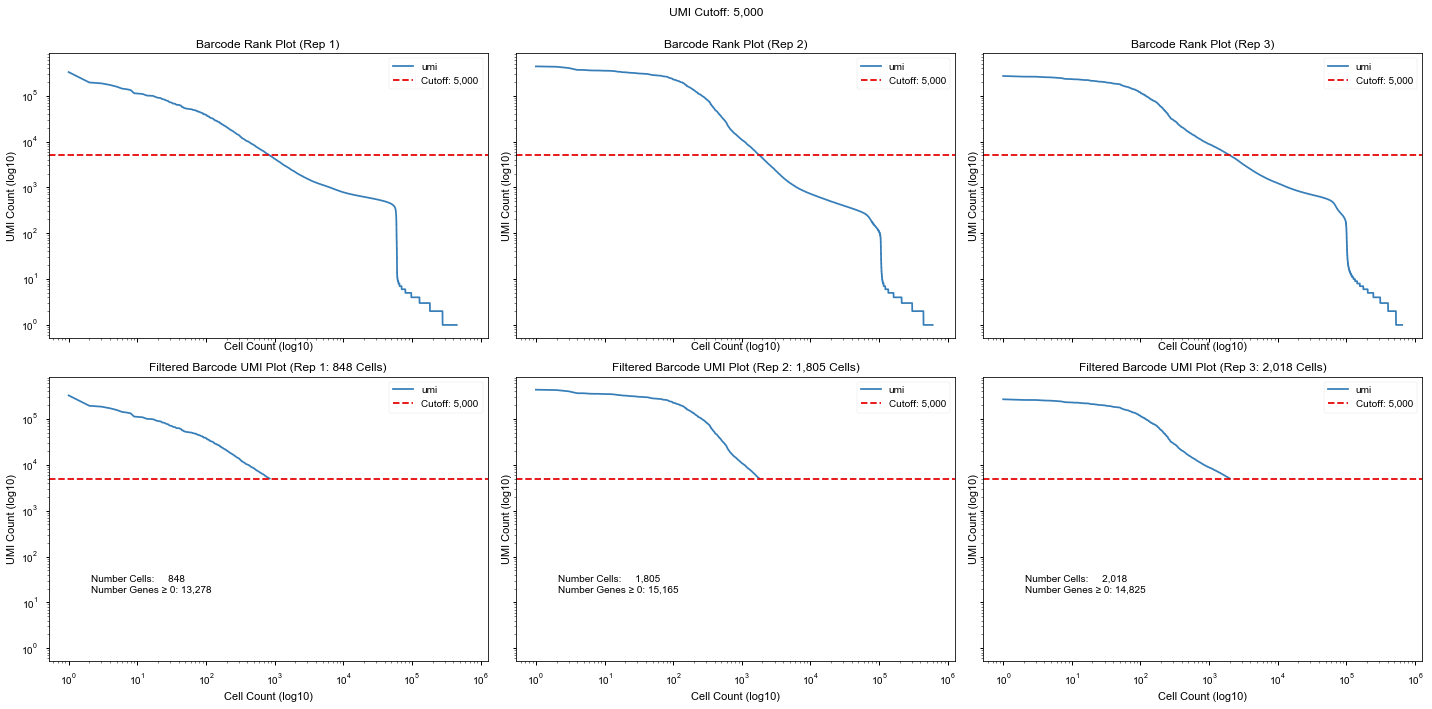

In [5]:
%%time
plot_cutoff(5000)

In [6]:
store = pd.HDFStore('../output/store.h5')

In [18]:
umi = cellranger_umi('../output/testis1/outs/molecule_info.h5')

In [19]:
umi.head()

,cell_id,read_cnt,umi
0,24674567,1,353237
1,24674573,1,434802
2,24674778,1,569888
3,24674778,1,766759
4,24674825,0,135300


In [24]:
cell_ids = umi.cell_id.unique()

array([  24674567,   24674573,   24674778, ..., 4275273470, 4275273489,
       4275273517], dtype=uint64)